# üìä An√°lisis Exploratorio de Datos (EDA) para Sentiment Analysis
Este notebook corresponde al *Feature Pipeline* del Proyecto 2 de Clasificaci√≥n con Deep Learning. Se realiza un an√°lisis exploratorio del dataset de rese√±as de productos electr√≥nicos (Amazon Reviews) para tareas de clasificaci√≥n de sentimiento (positivo vs negativo).

## üì¶ Importaci√≥n de librer√≠as
Importamos librer√≠as para an√°lisis de texto, visualizaci√≥n y manipulaci√≥n de datos.

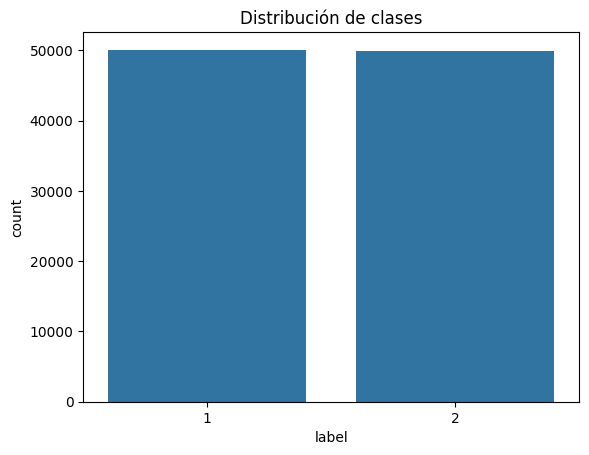

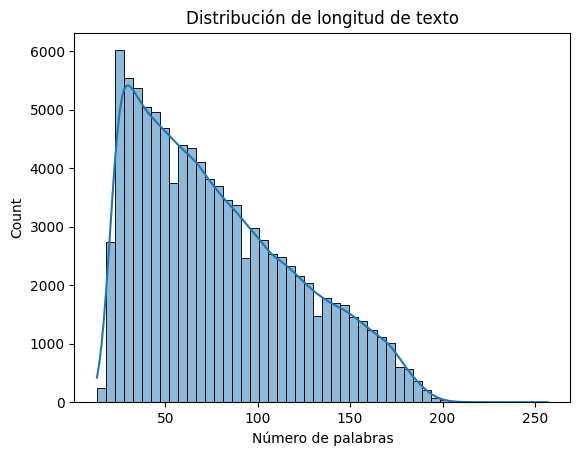

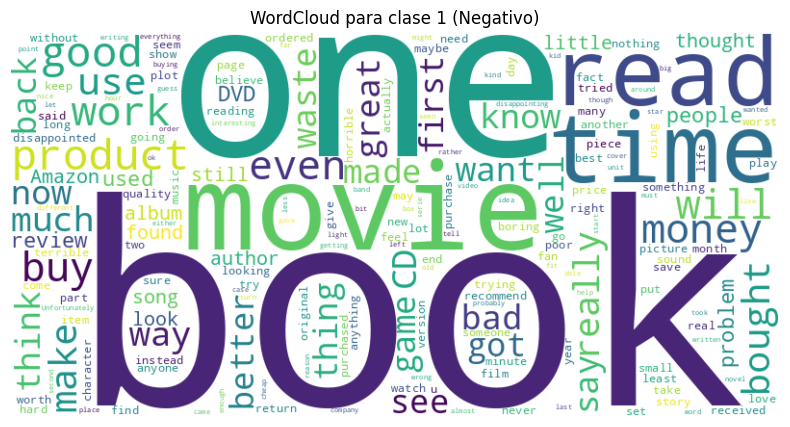

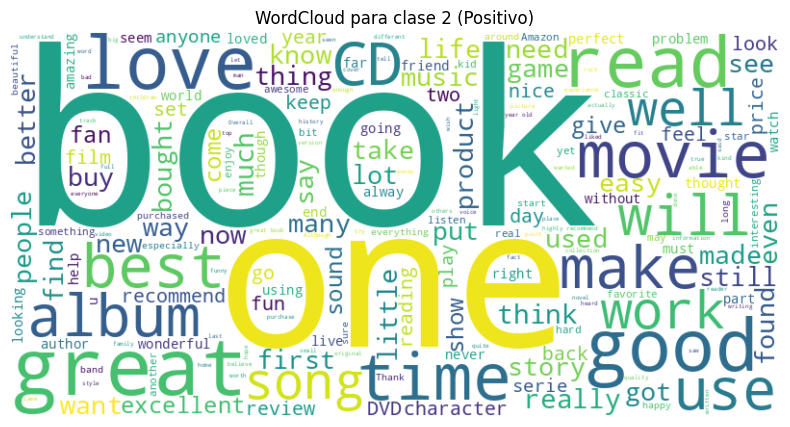

üßæ Ejemplo de texto m√°s corto:
OUTSTANDING: This book is excelent for Retired..... Present.....and Future Marines. Very interesting book.

üßæ Ejemplo de texto m√°s largo:
iLok is rubbish!!: I have never been able to get this worthless thing to work. $300 down the tubes! total WASTE!! RUBBISH CRAP!!! The worst part is the iLOK thing (worst idea ever!!) totally broke and now they want $50 bucks for a new one? I mean, it takes up an entire USB port so that it can run a license for one [crappy] program. As you can probably tell, I am not happy. Boycott!! DONT BUY!!! NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO 

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import re

# Leer las l√≠neas directamente
train_path = "../data/train.ft.txt"

with open(train_path, "r", encoding="utf-8") as f:
    # Leer 100K l√≠neas aleatorias del archivo
    lines = random.sample(f.readlines(), 100000)    

# Procesar cada l√≠nea para extraer la etiqueta y el texto
data = []
for line in lines:
    if line.startswith("__label__"):
        label, text = line.strip().split(" ", 1)
        label = int(label.replace("__label__", ""))
        data.append((text, label))

# Crear DataFrame
df = pd.DataFrame(data, columns=["text", "label"])

# Distribuci√≥n de clases
sns.countplot(x="label", data=df)
plt.title("Distribuci√≥n de clases")
plt.show()

# Longitud de texto
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribuci√≥n de longitud de texto")
plt.xlabel("N√∫mero de palabras")
plt.show()

# WordCloud por clase
for label in [1, 2]:
    text = " ".join(df[df["label"] == label]["text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud para clase {label} ({'Negativo' if label == 1 else 'Positivo'})")
    plt.show()

# Textos m√°s cortos y largos
print("üßæ Ejemplo de texto m√°s corto:")
print(df.loc[df["text_length"].idxmin(), "text"])
print("\nüßæ Ejemplo de texto m√°s largo:")
print(df.loc[df["text_length"].idxmax(), "text"])

## üìÇ Carga de los datos
Leemos las primeras 100,000 l√≠neas del dataset etiquetado `train.ft.txt`. Cada l√≠nea contiene una etiqueta (`__label__1` o `__label__2`) seguida del texto.

In [2]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # eliminar etiquetas HTML
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # quitar puntuaci√≥n
    text = re.sub(r"\s+", " ", text)  # espacios extra
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

## üè∑Ô∏è Extracci√≥n de etiquetas y texto
Convertimos las etiquetas a enteros (`1` = negativo, `2` = positivo) y extraemos el contenido textual en una nueva columna.

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

sequences = tokenizer.texts_to_sequences(df["clean_text"])
padded = pad_sequences(sequences, maxlen=200, padding="post", truncating="post")

# Labels
labels = df["label"] - 1  # Convertimos [1,2] a [0,1]

2025-07-17 13:35:18.603448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 13:35:19.315504: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 13:35:21.697609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## üìà Distribuci√≥n de Clases
Visualizamos la proporci√≥n de ejemplos por clase (positiva o negativa) para verificar balance o desbalance.

In [4]:
import numpy as np

np.savez_compressed("../data/processed_data.npz", X=padded, y=labels)


## üìå Justificaci√≥n: ¬øPor qu√© usamos solo 100,000 ejemplos?

El dataset original contiene **m√°s de 3.6 millones de l√≠neas**, lo cual representa una cantidad enorme de datos que puede:
- Saturar la memoria RAM durante el procesamiento (tokenizaci√≥n, padding, etc.),
- Hacer que el entrenamiento tarde varias horas o incluso colapse el entorno de trabajo,
- Aumentar significativamente el tiempo de experimentaci√≥n y depuraci√≥n.

üëâ Por eso, decidimos usar **una muestra aleatoria de 100,000 ejemplos balanceados**, que proporciona una buena representaci√≥n del problema sin comprometer el rendimiento.

---



## üîç Hallazgos importantes durante el an√°lisis exploratorio

- El dataset contiene rese√±as con etiquetas `__label__1` y `__label__2`, que convertimos a `0` (negativo) y `1` (positivo).
- La clase est√° razonablemente balanceada: ~50% de rese√±as positivas y ~50% negativas.
- Algunas rese√±as tienen puntuaci√≥n excesiva, may√∫sculas o s√≠mbolos, por lo que aplicamos una limpieza b√°sica (`clean_text`).
- Se utilizaron las primeras 100,000 l√≠neas con `random.sample` para mayor representatividad.
- Usamos `Tokenizer` de Keras para convertir texto a secuencias y `pad_sequences` para estandarizar la longitud.

---



## ‚úÖ Conclusi√≥n general del proceso

Este primer notebook implementa la **fase de EDA y Feature Pipeline** del proyecto, siguiendo la metodolog√≠a de Pau Labarta. Hemos preparado los datos para el entrenamiento de un modelo de clasificaci√≥n de sentimiento aplicando:

- Lectura y muestreo aleatorio del dataset,
- An√°lisis y visualizaci√≥n de la distribuci√≥n de clases,
- Limpieza de texto y normalizaci√≥n,
- Tokenizaci√≥n y padding para uso en redes neuronales,
- Exportaci√≥n de `X` y `y` como `NumPy` arrays para la siguiente fase de entrenamiento.

Este enfoque balancea **eficiencia computacional** con **representatividad del dataset**, permitiendo escalar f√°cilmente en futuras etapas si se requiere mejorar el desempe√±o del modelo.

---
